In [2480]:
import numpy as np
import matplotlib.pyplot as plt

In [2481]:
def im(grid, title = '', origin = 'lower'):
    plt.imshow(grid, origin=origin)
    plt.colorbar()
    plt.title(title)
    plt.show()

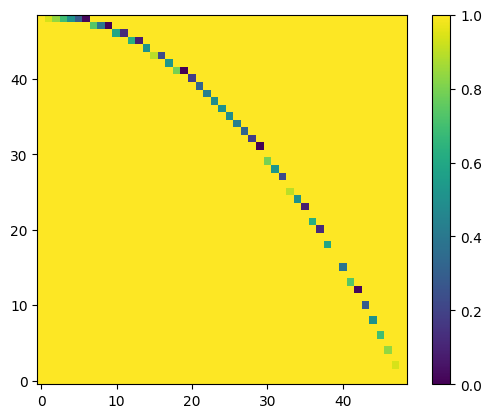

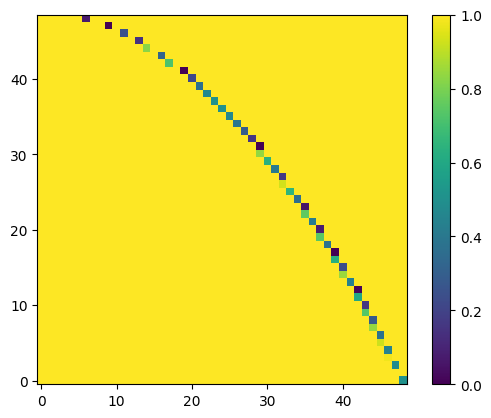

(2401,)


In [2482]:
def get_etaxi(M):
    h = 1/(M+1)
    x = np.linspace(0, 1, M+1)
    y = np.linspace(0, 1, M+1)
    xx, yy = np.meshgrid(x, y)

    xigrid = (np.sqrt(1 - yy) - xx)/h
    xigrid[xigrid<0] = 1
    xigrid[xigrid>1] = 1

    etagrid = ((1-xx**2) - yy)/h
    etagrid[etagrid<0] = 1
    etagrid[etagrid>1] = 1
    return etagrid[1:-1,1:-1].flatten(), xigrid[1:-1,1:-1].flatten()

M = 50
e, x = get_etaxi(M)
im(e.reshape((M-1,M-1)))
im(x.reshape((M-1,M-1)))
print(x.shape)

2401


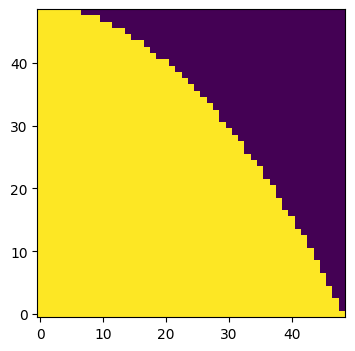

In [2483]:
num_points = 50

def bool_domain_gen(num_points):
    x = np.linspace(0, 1, num_points+1)
    y = np.linspace(0, 1, num_points+1)
    x_g, y_g = np.meshgrid(x, np.sqrt(1-y))
    #y_g = y_g[::-1]
    bool_domain = x_g < y_g
    return bool_domain[1:-1,1:-1]

bool_domain = bool_domain_gen(num_points)


plt.figure(figsize = (4,4))
plt.imshow(bool_domain, origin = 'lower')
print(bool_domain.size)

In [2484]:
def domain2(dom_mx):
    vec = np.zeros(len(dom_mx[0,:]))
    for i in range(len(vec)):
        vec[i] = np.sum(dom_mx[i])
    vec = vec.astype(int)
    return vec

print(domain2(bool_domain))

[49 48 48 47 47 46 46 45 45 44 44 43 43 42 41 41 40 39 39 38 38 37 36 36
 35 34 33 33 32 31 30 29 29 28 27 26 25 24 23 22 21 19 18 17 15 14 12 10
  7]


In [2485]:
def normal_dirichlet(boundaries, alpha = 1, beta = 1):
    """ Create a one-dimensional vector for Dirichlet conditions. Uses natural ordering.

    Args:
        G (array(4 x M-1)): Matrix with row vectors corresponding respectively to boundary at x = x0, y = y0, x = xend, y = yend
        alpha, beta (floats): Constants as defined in text. Optional arguments. 

    Returns:
        g (array(M-1)^2): One dimensional array meant for use in linear system, using natural ordering
    """
    l, t, r, b = boundaries
    M = l.shape[0] - 1         # l is M+1
    G = np.zeros((M-1, M-1))
    G[0, :] += beta * b[1:M]
    G[-1, :] += beta * t[1:M]
    G[:, 0] += alpha * l[1:M]
    G[:, -1] += alpha * r[1:M]
    """plt.imshow(G)
    plt.show()"""
    return G.flatten()


# Testing
M = 5
l = np.arange(M+1)
t = np.zeros(M+1)
r = np.zeros(M+1)
b = np.arange(M+1)

g2 = normal_dirichlet([l, t, r, b], 1, 1)
#G = np.flip(g2.reshape((M-1,M-1)), 0)
print(np.flip(g2.reshape((M-1,M-1)), 0))
#np.pad(G, [(1,1)])

[[4. 0. 0. 0.]
 [3. 0. 0. 0.]
 [2. 0. 0. 0.]
 [2. 2. 3. 4.]]


64.0
ah:3


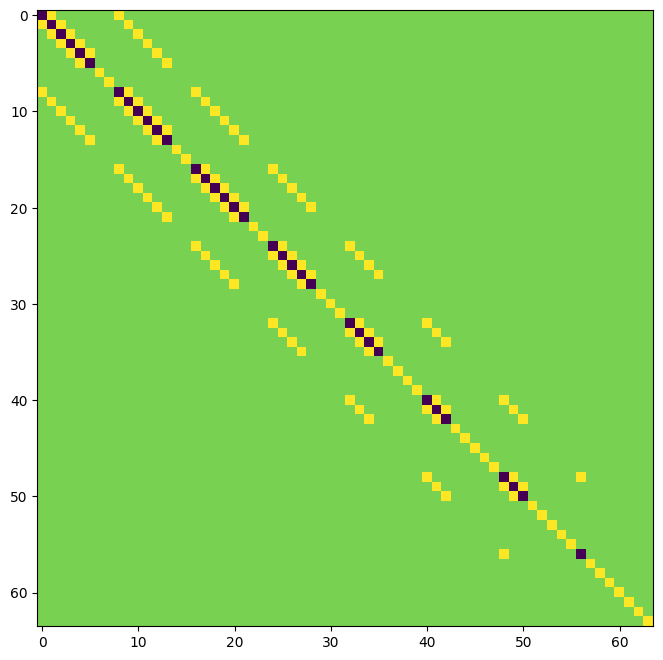

In [2486]:
def ndiag(consts, offsets, N):
    """Generate a matrix with arbitrary number of constant diagonals, 0 elsewhere

    Args:
        consts (list of floats):    list containing floats on diagonal
        offsets (list of ints):     list of offsets. Corresponds to the consts list
        N (int):                    length of array

    Returns:
        A (N x N matrix):           matrix with diagonals as specified
    """
    diags = []
    for i in range(len(consts)):
        diags.append(consts[i] * np.ones(N - np.abs(offsets[i])))

    A = np.zeros((N,N))
    for i in range(len(diags)):
        A += np.diag(diags[i], offsets[i])
    return A

def triblock_mod(C, B, M, domain_vec):
    A = np.kron(np.eye(M-1), C)
    A += np.kron(ndiag([1,1], [-1, 1], M-1), B)
    if np.size(A) != len(domain_vec)**4:
        print("np.size(A) != len(domain_vec)**4")
        print(np.size(A))
        print(len(domain_vec)**4)
    for i in range(len(domain_vec)):
        A[(i*(len(domain_vec))+domain_vec[i]):(i+1)*(len(domain_vec)), :] = 0
    print(np.sqrt(np.size(A)))
    for i in range(len(domain_vec)**2):
        if A[i,i] == 0:
            A[i,i] = 1
    for i in range(len(domain_vec)**2):
        if A[i,i] != 1:
            if A[i+1,i+1] == 1:
                A[i,i+1] = 0
            if i < len(domain_vec)**2 - len(domain_vec):
                if A[i+len(domain_vec),i+len(domain_vec)] == 1:
                    A[i, i+len(domain_vec)] = 0
        
    return A

# Testing
M = 9
C = ndiag([1,-4,1], [-1,0,1], (M-1))
B = 1 * np.eye(M-1)

A = triblock_mod(C, B, M, [6,6,6,5,4,3,3,1])

print("ah:"+str(len([3,2,1])))
plt.figure(0, figsize = (8,8))
plt.imshow(A)
plt.show()

In [2487]:
def equation_fixer(A, g2, domain_vec, M, b_function, fvec):
    h = 1/(M)
    count = 0
    etas, xis = get_etaxi(M)
    indexes_used = np.zeros((M-1)**2)
    if np.size(A) != len(domain_vec)**4:
        print("np.size(A) != len(domain_vec)**4")
    if np.size(A) != len(g2)**2:
        print("np.size(A) != len(g2)**2")
    for i in range(len(domain_vec)**2):
        if A[i,i] != 1 and i < len(domain_vec)**2 - len(domain_vec):     # outside of domain
            if A[i,i+1] == 0 or A[i, i+len(domain_vec)] == 0: # if east or north is removed
                indexes_used[i] = 1
                x_p = (i%len(domain_vec)+1)*h
                y_p = (i//len(domain_vec)+1)*h
                eta = etas[i]
                xsi = xis[i]
                etas[i] = 0.
                xis[i] = 0.
                #if eta == 1 and xsi == 1:
                    #pass
                if np.isclose(eta,0) or np.isclose(xsi,0):     # point is (close to) exactly on boundary
                    g2[i] = b_function(x_p, y_p)            # ! +-
                    print("ehwsasfdhdabfxv ")
                    fvec[i] = 0
                    A[i, :] = 0
                    A[i,i] = 1
                else:
                    A[i,i] = (-2/xsi - 2/eta)
                    if i > 0:                                       # Upper left corner excluded
                        A[i,i-1] *=  2 / ((1+xsi))
                    A[i, i+1] *= ( 2 / (xsi*(1+xsi)) )
                    if i > len(domain_vec):                         # exclude bottom
                        A[i, i-len(domain_vec)] *=  2 / ((1+eta))
                    else:
                        g2[i] *= 2 / (1 + eta)
                    if i < len(domain_vec)**2 - len(domain_vec):    # exclude top
                        A[i, i+len(domain_vec)] *=  ( 2 / (eta*(1+eta)))
                    if A[i,i+1] == 0 and (i%len(domain_vec)+1) <len(domain_vec):
                        g2[i] -= ( 2 / (xsi*(1+xsi)) ) * b_function(x_p + xsi*h, y_p)
                        #print(1 - (x_p + xsi*h)**2 - y_p)
              
                        #print("xih = ", xsi*h)
                    if i < len(domain_vec)**2 - len(domain_vec):
                        if A[i, i+len(domain_vec)] == 0:
                            g2[i] -= ( 2 / (eta*(1+eta)) ) * b_function(x_p, y_p + eta*h)
                            #print(1-x_p**2 - (y_p+ eta*h))
        elif A[i,i] != 1 and i >= len(domain_vec)**2 - len(domain_vec):
            indexes_used[i] = 1
            x_p = (i%len(domain_vec)+1)*h
            y_p = (i//len(domain_vec)+1)*h
            eta = etas[i]
            xsi = xis[i]
            g2[i] -= ( 2 / (eta*(1+eta)) ) * b_function(x_p, y_p + eta*h)
            A[i,i] = (-2/xsi - 2/eta)
            A[i, i-len(domain_vec)] *=  2 / ((1+eta))
            if A[i,i+1] == 0:

                if np.isclose(eta,0) or np.isclose(xsi,0):     # point is (close to) exactly on boundary
                    g2[i] = b_function(x_p, y_p)            # ! +-
                    fvec[i] = 0
                    A[i, :] = 0
                    A[i,i] = 1
                else:
                    if i > 0:                                       # Upper left corner excluded
                        A[i,i-1] *=  2 / ((1+xsi))
                    
                    A[i, i+1] *= ( 2 / (xsi*(1+xsi)) )
                    

                    if A[i,i+1] == 0 and (i%len(domain_vec)+1) <len(domain_vec):
                        g2[i] -= ( 2 / (xsi*(1+xsi)) ) * b_function(x_p + xsi*h, y_p)
                        #print(1 - (x_p + xsi*h)**2 - y_p)
                
                        #print("xih = ", xsi*h)

            
            
            
            
            
            
            
            
            """if A[i, i+1] == 0:
                eta = etas[i]
                xsi = xis[i]
                
                A[i,i] = (-2/xsi - 2/eta)
                g2[i] -= ( 2 / (xsi*(1+xsi)) ) * b_function(x_p + xsi*h, y_p)
                if i > 0:
                    A[i,i-1] *= 2 / (1 + xsi)
                A[i, i+1] *= 2 / (xsi*(1+xsi))
            x_p = (i%len(domain_vec)+1)*h
            y_p = (i//len(domain_vec)+1)*h
            eta = etas[i]
            g2[i] -= ( 2 / (eta*(1+eta)) ) * b_function(x_p, y_p + eta*h)"""
                           
    return A, g2, [etas,xis], indexes_used




left = np.arange(M+1)
top = np.zeros(M+1)
right = np.zeros(M+1)
bottom = np.arange(M+1)


g2 = normal_dirichlet([left, top, right, bottom], 1, 1)

def bndry_func(x,y):
    return x+y

#A, g2 = equation_fixer(A, g2, [4,3,3,1], M, bndry_func)
"""plt.figure(0, figsize = (5,5))
for i in range(int(np.sqrt(np.size(A)))):
    for j in range(int(np.sqrt(np.size(A)))):
        if A[i,j] == 0:
            A[i,j] = True
        else:
            A[i,j] = False
plt.imshow(A)
plt.show()"""

'plt.figure(0, figsize = (5,5))\nfor i in range(int(np.sqrt(np.size(A)))):\n    for j in range(int(np.sqrt(np.size(A)))):\n        if A[i,j] == 0:\n            A[i,j] = True\n        else:\n            A[i,j] = False\nplt.imshow(A)\nplt.show()'

In [2488]:
for i in range(int(np.sqrt(np.size(A)))):
    for j in range(int(np.sqrt(np.size(A)))):
        if A[i,j] == 0:
            A[i,j] = True
        else:
            A[i,j] = False

In [2489]:
def hyper_f_fixer(function_vec, domain_vec):
    mod_f_vec = function_vec
    for i in range(len(function_vec)):
        if function_vec[i] > domain_vec[i//len(domain_vec)]:
            mod_f_vec[i] = 0
    return mod_f_vec

2401.0
ehwsasfdhdabfxv 


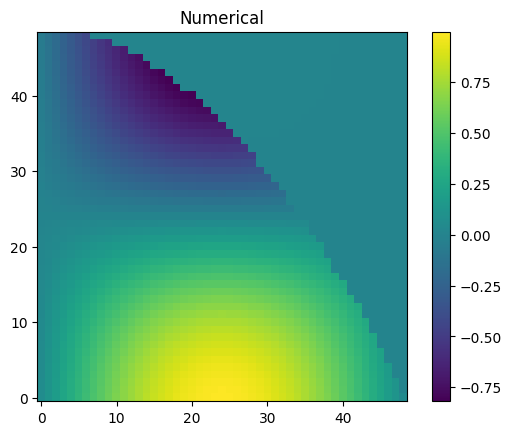

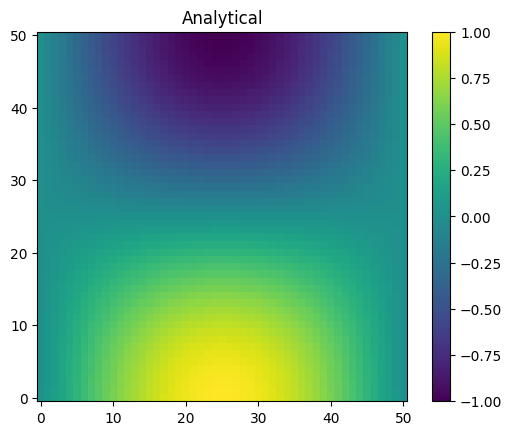

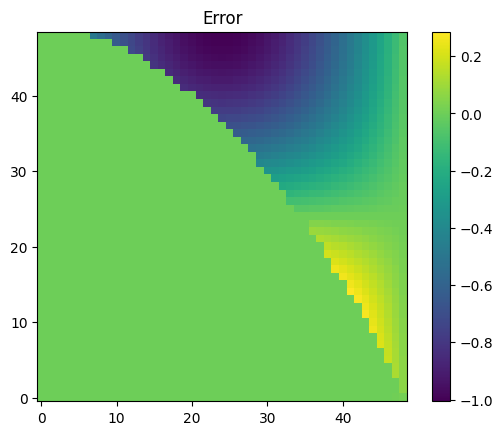

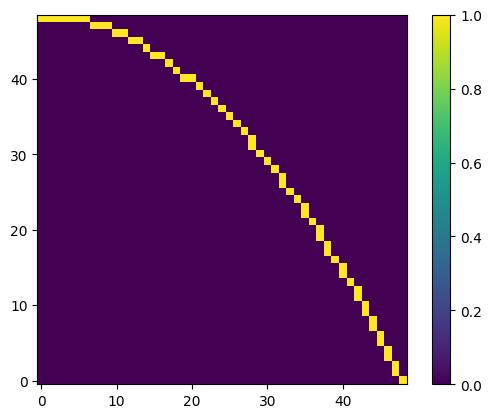

In [2490]:
M = 50
h = 1/M


def hyper_bndry_func(x,y):
    return -np.sin(np.pi * x) * np.cos(np.pi * y)

def u_exact(x, y):
    return np.sin(np.pi * x) * np.cos(np.pi * y)

def f(x, y):
    return np.pi**2 * (2) * np.sin(np.pi * x) * np.cos(np.pi * y) 

x = np.linspace(0, 1, M+1)
y = np.linspace(0, 1, M+1)
xx, yy = np.meshgrid(x, y)
fmat = f(xx, yy)[1:-1, 1:-1]
fvec = fmat.flatten()
U_exact = u_exact(xx, yy)


left = U_exact[:, 0]
top = np.zeros(M+1)
right = np.zeros(M+1)
bottom = U_exact[0, :]
g2 = normal_dirichlet([left, top, right, bottom], 1, 1)

omega = domain2(bool_domain_gen(M))

hyper_function = hyper_f_fixer(fvec, omega)

C = ndiag([1,-4,1], [-1,0,1], (M-1))
B = 1 * np.eye(M-1)
A = triblock_mod(C, B, M, omega)

A, g2, used, indexes_used = equation_fixer(A, g2, omega, M, hyper_bndry_func, hyper_function)
G = g2.reshape((M-1,M-1))
U_vec = np.linalg.solve(A, -g2 - hyper_function*h**2)
U = U_vec.reshape((M-1, M-1))

im(U, 'Numerical')
im(U_exact, 'Analytical')
im(U_exact[1:-1,1:-1] - U, 'Error')

im(indexes_used.reshape((M-1,M-1)) )

M array:  [16 32 64]
225.0
961.0
3969.0


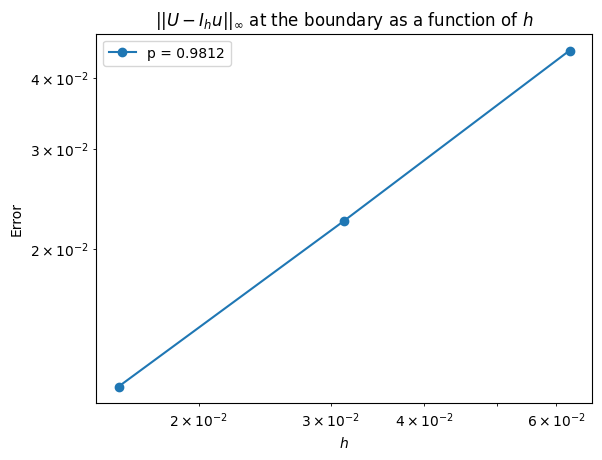

In [2491]:
def hyper_bndry_func(x,y):
    return -np.sin(np.pi * x) * np.cos(np.pi * y)

def u_exact(x, y):
    return np.sin(np.pi * x) * np.cos(np.pi * y)

def f(x, y):
    return np.pi**2 * (2) * np.sin(np.pi * x) * np.cos(np.pi * y) 

num_points = 3
Ms = 2**np.arange(4, 4+num_points) 
print("M array: ", Ms)
hs = 1 / Ms

errors = np.zeros(num_points)

for i in range(num_points):
    M = Ms[i]
    h = hs[i]

    x = np.linspace(0, 1, M+1)
    y = np.linspace(0, 1, M+1)
    xx, yy = np.meshgrid(x, y)
    fmat = f(xx, yy)[1:-1, 1:-1]
    fvec = fmat.flatten()
    U_exact = u_exact(xx, yy)

    left = U_exact[:, 0]
    top = np.zeros(M+1)
    right = np.zeros(M+1)
    bottom = U_exact[0, :]
    g2 = normal_dirichlet([left, top, right, bottom], 1, 1)

    omega = domain2(bool_domain_gen(M))

    hyper_function = hyper_f_fixer(fvec, omega)

    C = ndiag([1,-4,1], [-1,0,1], (M-1))
    B = 1 * np.eye(M-1)
    A = triblock_mod(C, B, M, omega)
    A, g2, used, indexes_used = equation_fixer(A, g2, omega, M, hyper_bndry_func, hyper_function)

    U_vec = np.linalg.solve(A, -g2 - hyper_function*h**2)
    U = U_vec.reshape((M-1, M-1))

    boundary_bool = indexes_used.reshape((M-1, M-1))
    analytical_boundary = U_exact[1:-1, 1:-1] * boundary_bool
    numerical_boundary = U * boundary_bool
    errors[i] = np.max(np.abs(analytical_boundary - numerical_boundary))

order = np.polyfit(np.log(hs),np.log(errors), 1)[0]

plt.loglog(hs, errors, '-o', label = 'p = {:.4f}'.format(order))
plt.xlabel(r'$h$')
plt.ylabel('Error')
plt.title(r'$||U-I_{h}u||_\infty$ at the boundary as a function of $h$')
plt.legend()
plt.show()